# Prediction de la demande d'electricite avec Xgboost

## Importation des packages necessaires

In [1]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import time
import pmdarima as pm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

## Creation du Frame

In [2]:
import glob
import os

all_files = glob.glob("archive/*.csv")
df = pd.concat((pd.read_csv(f) for f in all_files))

## Affichage de l'entete du frame

In [3]:
df

,REGION,SETTLEMENTDATE,TOTALDEMAND,RRP,PERIODTYPE
0,NSW1,2018/01/01 00:30:00,6912.25,91.86,TRADE
1,NSW1,2018/01/01 01:00:00,6745.63,88.83,TRADE
2,NSW1,2018/01/01 01:30:00,6466.06,73.62,TRADE
3,NSW1,2018/01/01 02:00:00,6279.80,71.49,TRADE
4,NSW1,2018/01/01 02:30:00,6177.31,69.27,TRADE
...,...,...,...,...,...
7771,NSW1,2023/06/27 23:40:00,8536.43,116.99,TRADE
7772,NSW1,2023/06/27 23:45:00,8527.02,89.00,TRADE
7773,NSW1,2023/06/27 23:50:00,8489.29,88.88,TRADE
7774,NSW1,2023/06/27 23:55:00,8358.07,61.74,TRADE


## Supprimer les colonnes inutiles

In [4]:
df.drop(['REGION', 'PERIODTYPE'], axis =1, inplace=True)
df.head()

,SETTLEMENTDATE,TOTALDEMAND,RRP
0,2018/01/01 00:30:00,6912.25,91.86
1,2018/01/01 01:00:00,6745.63,88.83
2,2018/01/01 01:30:00,6466.06,73.62
3,2018/01/01 02:00:00,6279.80,71.49
4,2018/01/01 02:30:00,6177.31,69.27


## Renommer les colonnes

In [5]:
#df = df.rename({"old-name-col1":"new-name-col1", "old-name-col2":"new-name-col2",},axis=1)
df = df.rename({"TOTALDEMAND":"demande", "RRP":"prix", "SETTLEMENTDATE":"date",},axis=1)

In [6]:
target_colonne_original = "demande"
target_colonne = "demande"

## Definir la colonne index

In [8]:
df = df.set_index("date")
df.head()

,demande,prix
date,,
2018/01/01 00:30:00,6912.25,91.86
2018/01/01 01:00:00,6745.63,88.83
2018/01/01 01:30:00,6466.06,73.62
2018/01/01 02:00:00,6279.80,71.49
2018/01/01 02:30:00,6177.31,69.27


## Mettre la date (l'index) sous un format exploitable

In [9]:
df.index = pd.to_datetime(df.index, format="mixed")
df.head()

,demande,prix
date,,
2018-01-01 00:30:00,6912.25,91.86
2018-01-01 01:00:00,6745.63,88.83
2018-01-01 01:30:00,6466.06,73.62
2018-01-01 02:00:00,6279.80,71.49
2018-01-01 02:30:00,6177.31,69.27


## Classer le frame par date croissante

In [10]:
df.sort_values(by=['date'], inplace=True)
df.head()

,demande,prix
date,,
2018-01-01 00:30:00,6912.25,91.86
2018-01-01 01:00:00,6745.63,88.83
2018-01-01 01:30:00,6466.06,73.62
2018-01-01 02:00:00,6279.80,71.49
2018-01-01 02:30:00,6177.31,69.27


## Afficher le frame

<Axes: xlabel='date'>

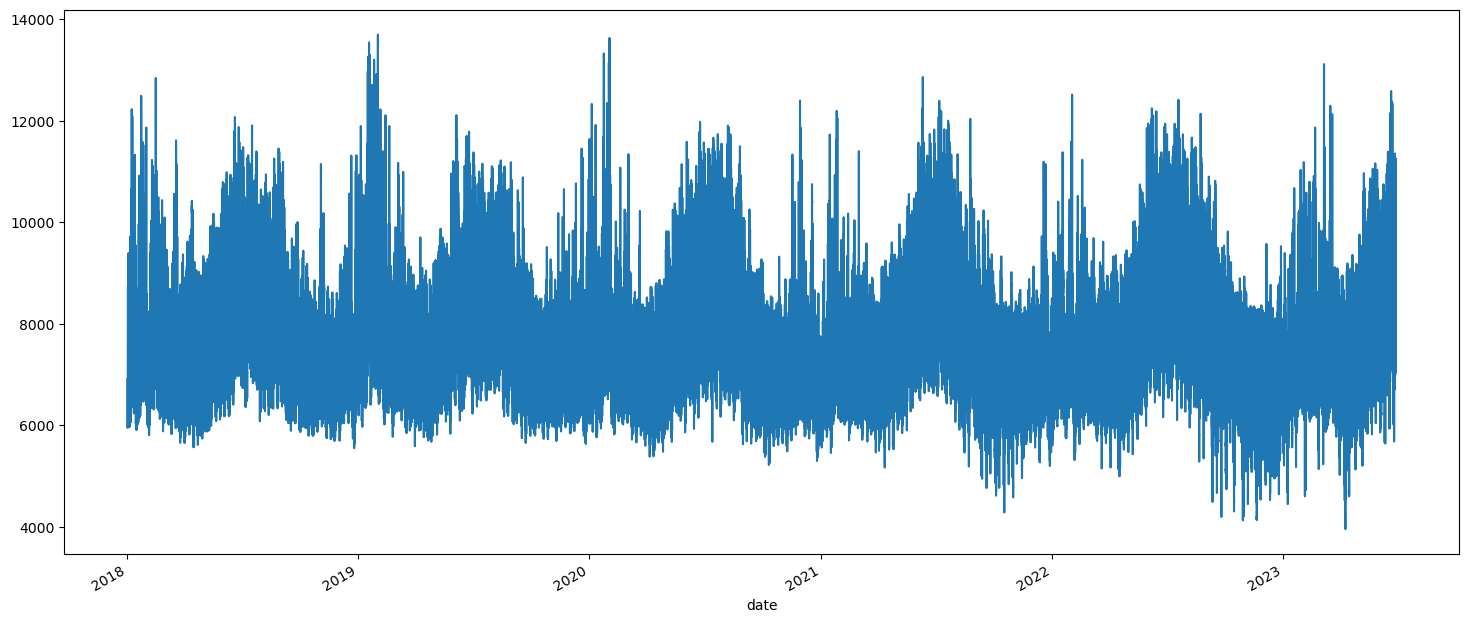

In [11]:
df.demande.plot(figsize=[18,8])

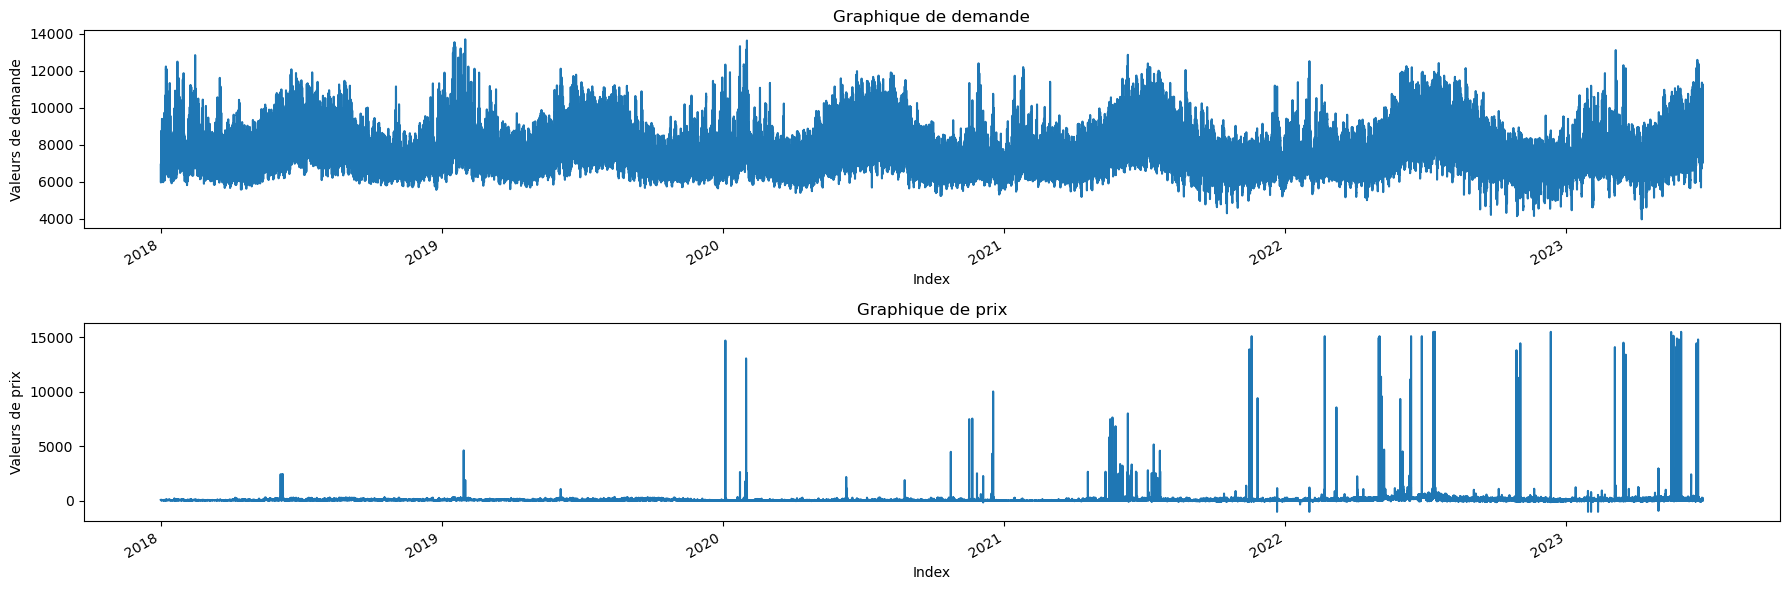

In [12]:
num_columns = len(df.columns)

fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(18, 3*num_columns))

for i, column in enumerate(df.columns):
    df[column].plot(ax=axes[i])
    axes[i].set_title(f'Graphique de {column}')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(f'Valeurs de {column}')

plt.tight_layout()
plt.show()

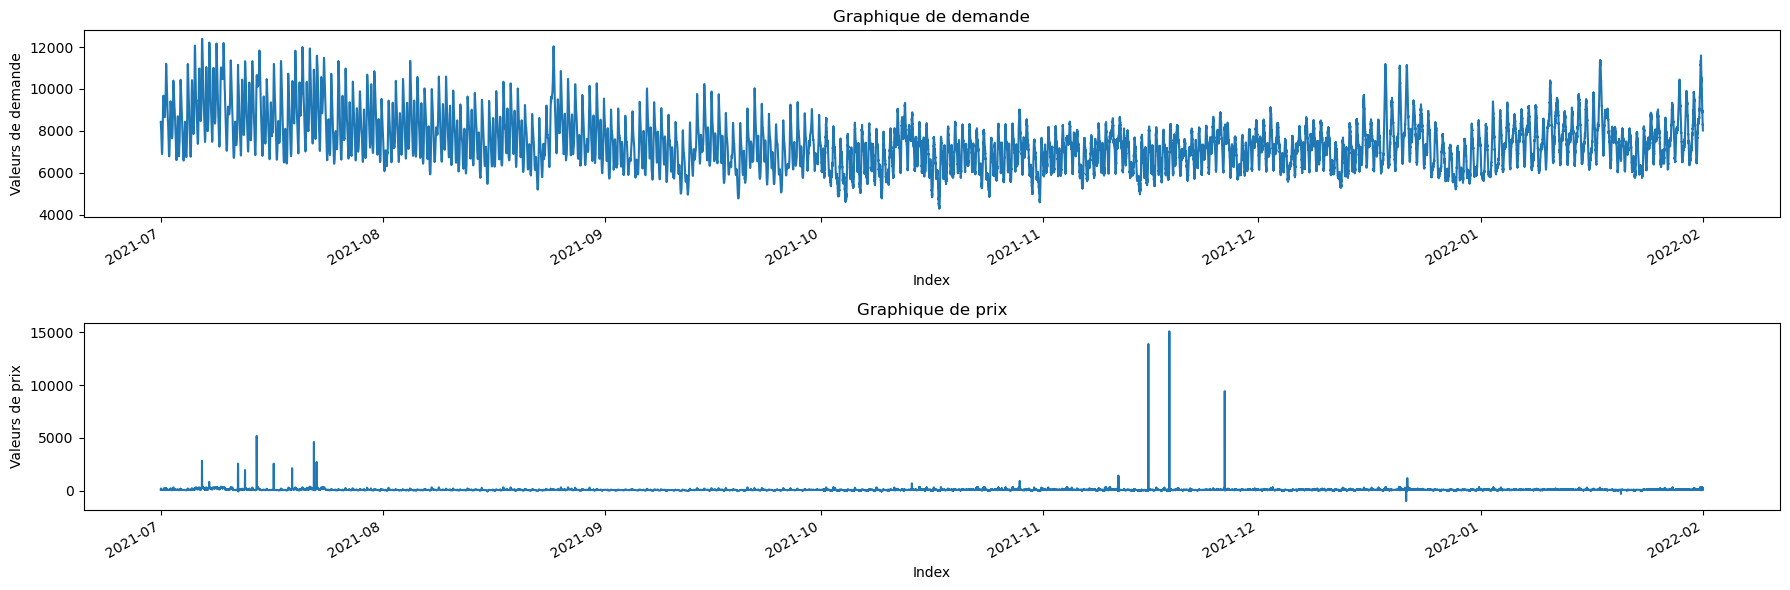

In [13]:
num_columns = len(df.columns)

start_date = '2021-07-01'
end_date = '2022-01-31'

df_filtered = df.loc[start_date:end_date]

fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(18, 3*num_columns))

for i, column in enumerate(df.columns):
    df_filtered[column].plot(ax=axes[i])
    axes[i].set_title(f'Graphique de {column}')
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel(f'Valeurs de {column}')

plt.tight_layout()
plt.show()

## Tracer le PACF

In [ ]:
plt.figure(figsize=(10, 6))
plot_pacf(df[target_colonne_original], lags=40, ax=plt.gca()) 
plt.title(f'Partial Autocorrelation Function (PACF) for {column}')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

## Quelques stats

In [ ]:
# Sélection de la colonne pour les statistiques
colonne = df[target_colonne_original]

# Calcul des statistiques
moyenne = colonne.mean()
variance = colonne.var()
ecart_type = colonne.std()
minimum = colonne.min()
maximum = colonne.max()
quantiles = colonne.quantile([0.25, 0.5, 0.75])

# Affichage des statistiques
print(f"Moyenne: {moyenne}")
print(f"Variance: {variance}")
print(f"Écart type: {ecart_type}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")
print(f"Quantiles:\n{quantiles}")

# Résumé des statistiques avec describe()
description = colonne.describe()
print("\nDescription complète:")
print(description)

## Afficher les donnees sous certaines conditions

In [14]:
df[df[target_colonne] > 10000]

,demande,prix
date,,
2018-01-06 15:00:00,10157.24,86.70
2018-01-06 15:30:00,10338.83,89.49
2018-01-06 16:00:00,10509.42,94.77
2018-01-06 16:30:00,10578.21,100.03
2018-01-06 17:00:00,10658.87,94.58
...,...,...
2023-06-27 20:35:00,10191.01,135.18
2023-06-27 20:40:00,10175.35,140.02
2023-06-27 20:45:00,10140.97,138.00


In [15]:
df[(df.index > "2022-10-10") & (df.index <= "2022-10-17")]

,demande,prix
date,,
2022-10-10 00:05:00,7032.45,299.99
2022-10-10 00:10:00,6996.44,299.99
2022-10-10 00:15:00,6979.87,299.99
2022-10-10 00:20:00,6906.34,299.16
2022-10-10 00:25:00,6913.04,298.99
...,...,...
2022-10-16 23:40:00,6702.20,163.00
2022-10-16 23:45:00,6699.04,163.00
2022-10-16 23:50:00,6702.53,160.73


## Creation des Features

In [16]:
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france import JoursFeries
from datetime import date
import holidays

In [17]:
def set_features(df):
    # Copie du dataframe original pour éviter de le modifier directement
    df = df.copy()
    
    # Ajout des caractéristiques temporelles
    df["minuteofhour"] = df.index.minute  # Minute de l'heure
    df['minuteofday'] = df.index.hour * 60 + df.index.minute  # Minute du jour
    df['minuteofmonth'] = df.index.day * 24 * 60 + df['minuteofday']  # Minute du mois
    df['minuteofyear'] = df.index.dayofyear * 24 * 60 + df['minuteofday']  # Minute de l'année
    df["hourofday"] = df.index.hour  # Heure de la journée
    df['hourofmonth'] = df.index.day * 24 + df['hourofday']  # Heure du mois
    df['hourofyear'] = df.index.dayofyear * 24 + df['hourofday']  # Heure de l'année
    df['dayofweek'] = df.index.dayofweek  # Jour de la semaine (lundi=0, dimanche=6)
    df["dayofmonth"] = df.index.day  # Jour du mois
    df["dayofyear"] = df.index.dayofyear  # Jour de l'année
    df['weekofmonth'] = (df['dayofmonth'] - 1) // 7 + 1  # Semaine du mois
    df['weekofyear'] = df.index.isocalendar().week
    df['month'] = df.index.month  # Mois de l'année
    df['quarter'] = df.index.quarter  # Trimestre de l'année
    df["year"] = df.index.year  # Année
    return df

In [18]:
df = set_features(df)
df

,demande,prix,minuteofhour,minuteofday,minuteofmonth,minuteofyear,hourofday,hourofmonth,hourofyear,dayofweek,dayofmonth,dayofyear,weekofmonth,weekofyear,month,quarter,year
date,,,,,,,,,,,,,,,,,
2018-01-01 00:30:00,6912.25,91.86,30,30,1470,1470,0,24,24,0,1,1,1,1,1,1,2018
2018-01-01 01:00:00,6745.63,88.83,0,60,1500,1500,1,25,25,0,1,1,1,1,1,1,2018
2018-01-01 01:30:00,6466.06,73.62,30,90,1530,1530,1,25,25,0,1,1,1,1,1,1,2018
2018-01-01 02:00:00,6279.80,71.49,0,120,1560,1560,2,26,26,0,1,1,1,1,1,1,2018
2018-01-01 02:30:00,6177.31,69.27,30,150,1590,1590,2,26,26,0,1,1,1,1,1,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-27 23:40:00,8536.43,116.99,40,1420,40300,257740,23,671,4295,1,27,178,4,26,6,2,2023
2023-06-27 23:45:00,8527.02,89.00,45,1425,40305,257745,23,671,4295,1,27,178,4,26,6,2,2023
2023-06-27 23:50:00,8489.29,88.88,50,1430,40310,257750,23,671,4295,1,27,178,4,26,6,2,2023


In [19]:
def set_holidays(df, country, state, start_year, end_year):
    # Copie du dataframe original pour éviter de le modifier directement
    df = df.copy()
    
    # Création d'un dictionnaire contenant les dates des jours fériés
    list_holidays = holidays.CountryHoliday(country, state=state, years=range(start_year, end_year+1))
    
    # Ajout d'une colonne pour les jours fériés
    df['holidays'] = df.index.to_series().apply(lambda x: 1 if x in list_holidays else 0)
    
    return df

In [20]:
df = set_holidays(df, "FRA", "Métropole", 2018, 2023)
df

,demande,prix,minuteofhour,minuteofday,minuteofmonth,minuteofyear,hourofday,hourofmonth,hourofyear,dayofweek,dayofmonth,dayofyear,weekofmonth,weekofyear,month,quarter,year,holidays
date,,,,,,,,,,,,,,,,,,
2018-01-01 00:30:00,6912.25,91.86,30,30,1470,1470,0,24,24,0,1,1,1,1,1,1,2018,1
2018-01-01 01:00:00,6745.63,88.83,0,60,1500,1500,1,25,25,0,1,1,1,1,1,1,2018,1
2018-01-01 01:30:00,6466.06,73.62,30,90,1530,1530,1,25,25,0,1,1,1,1,1,1,2018,1
2018-01-01 02:00:00,6279.80,71.49,0,120,1560,1560,2,26,26,0,1,1,1,1,1,1,2018,1
2018-01-01 02:30:00,6177.31,69.27,30,150,1590,1590,2,26,26,0,1,1,1,1,1,1,2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-27 23:40:00,8536.43,116.99,40,1420,40300,257740,23,671,4295,1,27,178,4,26,6,2,2023,0
2023-06-27 23:45:00,8527.02,89.00,45,1425,40305,257745,23,671,4295,1,27,178,4,26,6,2,2023,0
2023-06-27 23:50:00,8489.29,88.88,50,1430,40310,257750,23,671,4295,1,27,178,4,26,6,2,2023,0


## Numeriser au besoin toutes les colonnes qui ne sont pas numeriques

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248592 entries, 2018-01-01 00:30:00 to 2023-06-28 00:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   demande        248592 non-null  float64
 1   prix           248592 non-null  float64
 2   minuteofhour   248592 non-null  int32  
 3   minuteofday    248592 non-null  int32  
 4   minuteofmonth  248592 non-null  int32  
 5   minuteofyear   248592 non-null  int32  
 6   hourofday      248592 non-null  int32  
 7   hourofmonth    248592 non-null  int32  
 8   hourofyear     248592 non-null  int32  
 9   dayofweek      248592 non-null  int32  
 10  dayofmonth     248592 non-null  int32  
 11  dayofyear      248592 non-null  int32  
 12  weekofmonth    248592 non-null  int32  
 13  weekofyear     248592 non-null  UInt32 
 14  month          248592 non-null  int32  
 15  quarter        248592 non-null  int32  
 16  year           248592 non-null  int32  


## Test de stationnarité

## Visualization

-Quand les boxes sont alignes et ont les memes dimensions on soupsonne une saisonalite

-Quand on voit un motif apparaitre aussi

NB: COMMENCER L4AFFICHAGE PAR LA PLUS PETIT PERIODE QUE VOUS PUISSIEZ IMAGINER ET AUGMENTEZ PETIT A PETIT. DES QUE VOUS TROUVEZ UNE PERIODE ARRETEZ VOUS !!!

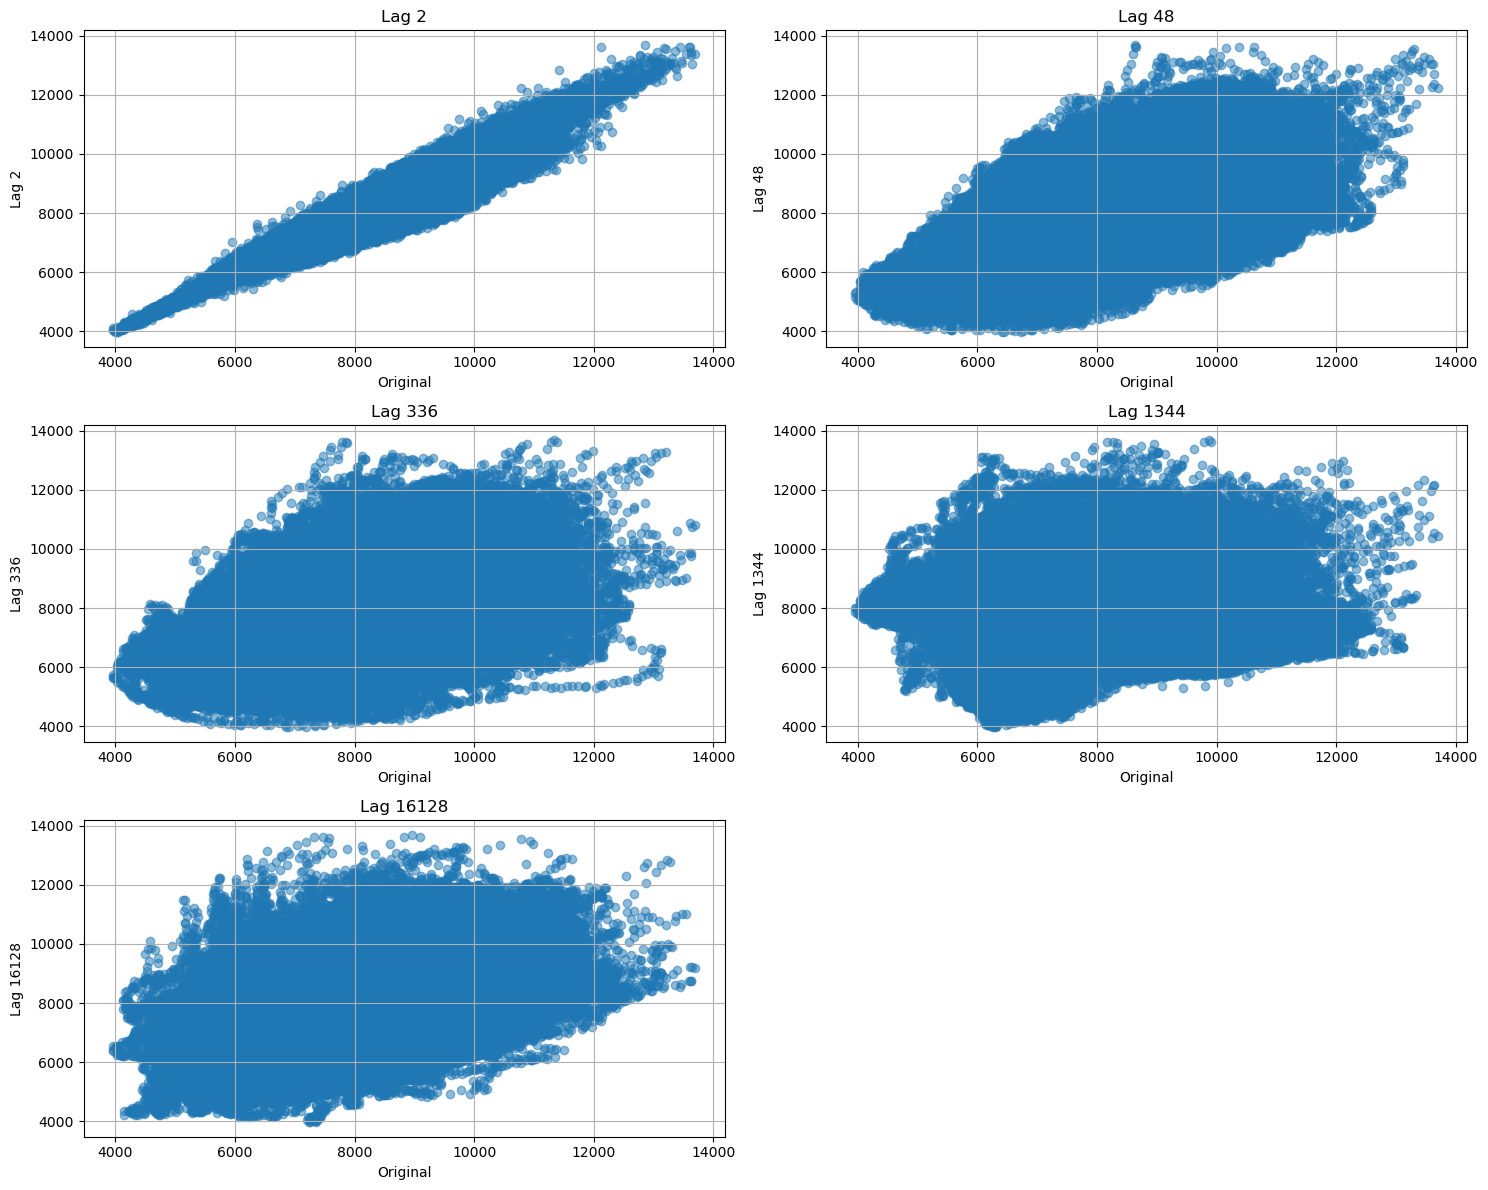

In [22]:
# Fonction pour tracer les séries temporelles décalées
def plot_time_lagged_series(series, lags):
    """
    Plots the original series against its lagged versions based on the provided lags.

    Parameters:
    series (pd.Series): The original time series data.
    lags (list): A list of lag values to shift the series by.
    """
    n_lags = len(lags)  # Nombre de lags
    n_cols = 2  # Nombre de colonnes de la grille
    n_rows = (n_lags + 1) // n_cols  # Calcul du nombre de lignes nécessaires
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))

    for i, lag in enumerate(lags):
        row = i // n_cols
        col = i % n_cols
        lagged_series = series.shift(lag)
        axes[row, col].scatter(series, lagged_series, alpha=0.5)
        axes[row, col].set_title(f'Lag {lag}')
        axes[row, col].set_xlabel('Original')
        axes[row, col].set_ylabel(f'Lag {lag}')
        axes[row, col].grid(True)

    # Masquer les sous-graphiques inutilisés
    for j in range(i + 1, n_rows * n_cols):
        row = j // n_cols
        col = j % n_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Tableau de valeurs de lag en fonction des unités de temps et des periodes a verifier
lags = [2, 2*24, 2*24*7, 2*24*7*4, 2*24*7*4*12] # Lag en heures, jours, semaines, mois et années

# Afficher les plots décalés en temps
plot_time_lagged_series(df[target_colonne], lags)

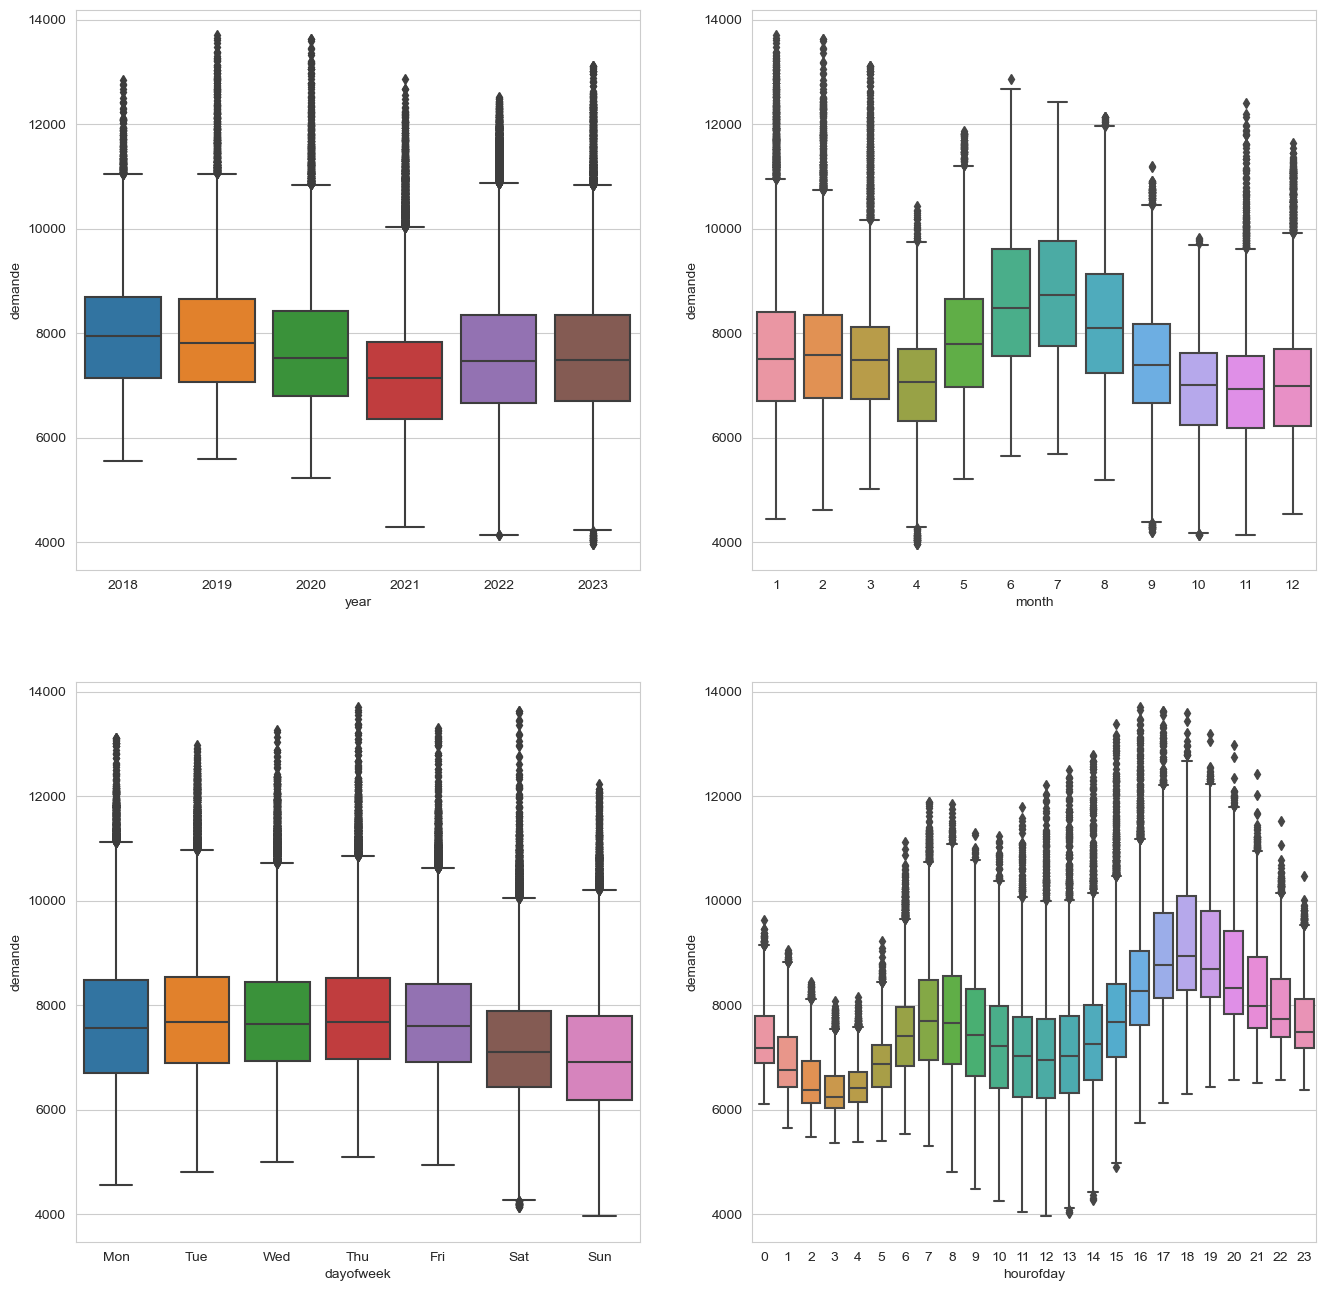

In [23]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16,16)
fig, axes = plt.subplots(2,2, figsize=(16, 16))
                        
#Model
#tableau_des_abscisses = ['', ''] #si on veut changer les valeur numeriques en valeur alphabetiques plus parlantes
#g = sns.boxplot(x = 'colonne_abscisse', y = 'colonne_ordonnee', data = df, ax=axes[i][j]) #la figure sera dessinnee en position i,j
#g.set_xticklabels(tableau_des_abscisses) #on change les valeurs numeriques en valeurs alphabetiques si on le souhaite

year_labels = range(2018, 2024)
g = sns.boxplot(x = 'year', y = target_colonne, data = df, ax=axes[0][0])
g.set_xticklabels(year_labels)

g = sns.boxplot(x = 'month', y = target_colonne, data = df, ax=axes[0][1])

dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x = 'dayofweek', y = target_colonne, data = df, ax=axes[1][0])
g.set_xticklabels(dow_labels)

g = sns.boxplot(x = 'hourofday', y = target_colonne, data = df, ax=axes[1][1])

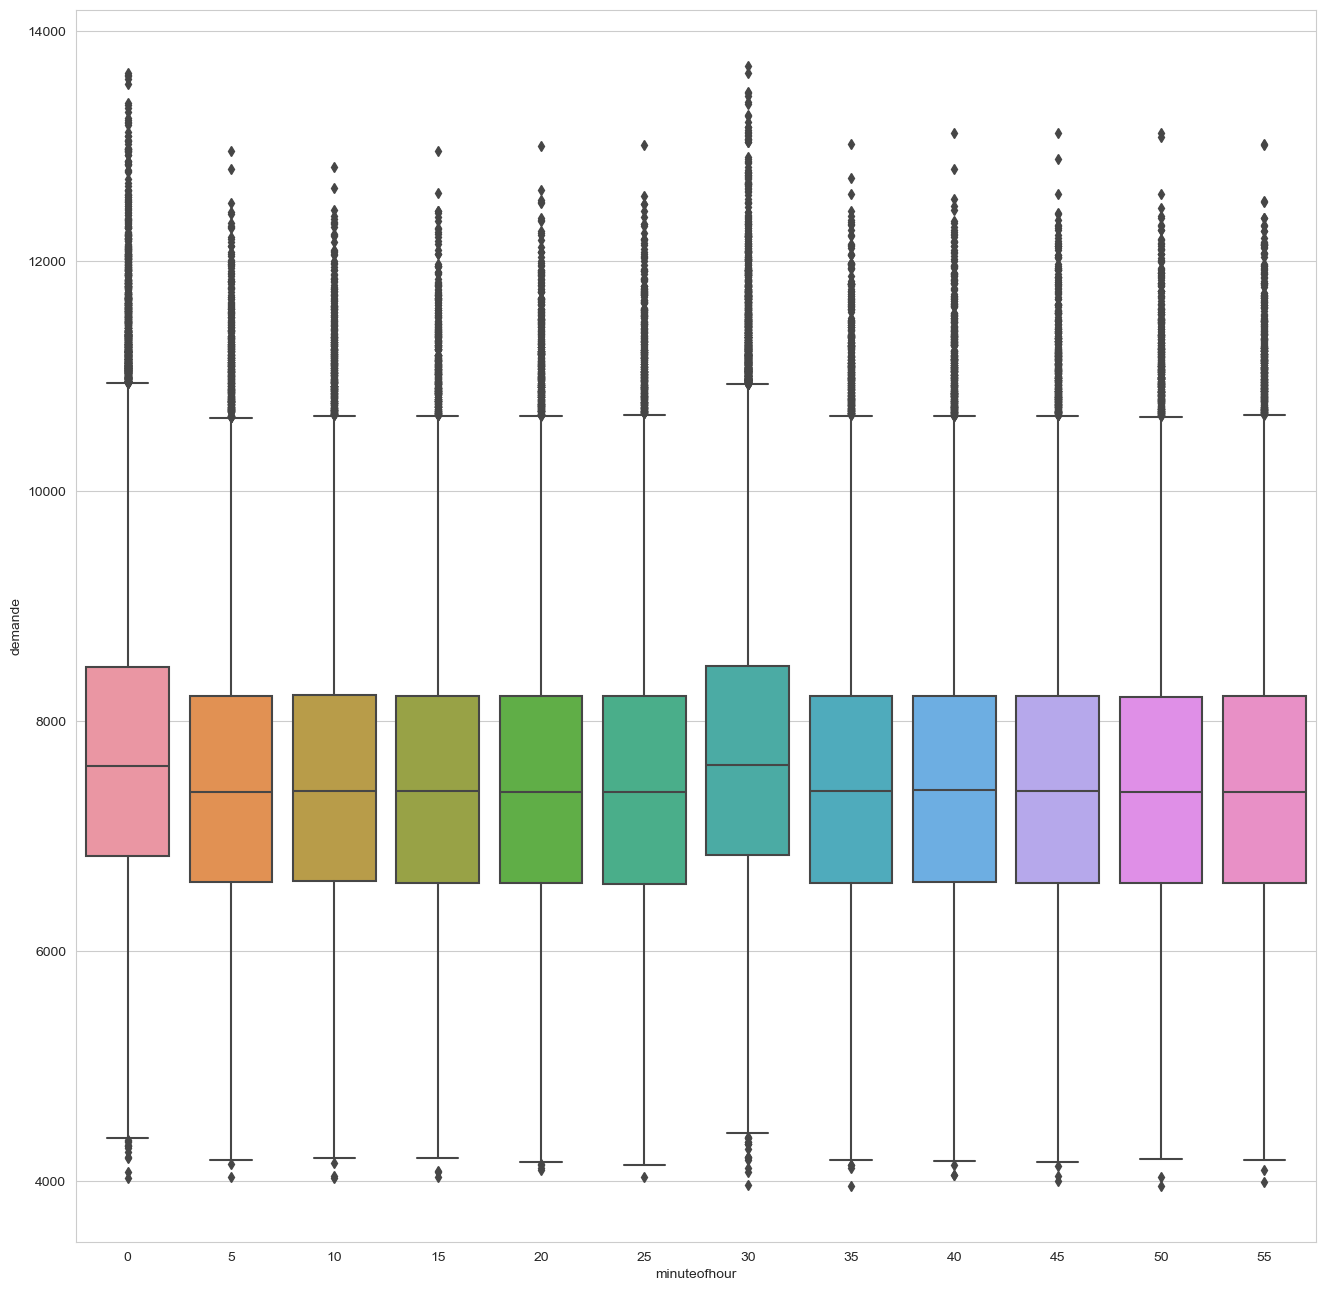

In [24]:
g = sns.boxplot(x = 'minuteofhour', y = target_colonne , data = df)

## Trouver les parametres pour rendre stationnaire

In [25]:
def check_stationarity_with_pvalue(series, alpha):
    result = adfuller(series.dropna())
    return result[1] < alpha, result[1]

def stationarity_method(df, target_column, tableau_periode, alpha_list):
    best_p_value = float('inf')
    best_periode = -1
    best_k = -1
    best_alpha = None
    is_stationary = False
    p_value_orig_best = float('inf')
    alpha_best = alpha_list[0]
    for alpha in alpha_list:
        is_stationary_orig, p_value_orig = check_stationarity_with_pvalue(df[target_column], alpha)
        if is_stationary_orig and p_value_orig < p_value_orig_best:
            p_value_orig_best = p_value_orig
            is_stationary = True
            alpha_best = alpha    
    if is_stationary:
        return 0, 0, alpha_best, p_value_orig_best    
    for periode in tableau_periode:
        lag_temp = df[target_column].rolling(window=periode+1).apply(lambda x: x.iloc[periode] - x.iloc[0]).dropna()    
        for alpha in alpha_list:
            k = pm.arima.ndiffs(lag_temp, alpha=alpha, test='adf', max_d=len(lag_temp))
            if k != 0:
                lag_temp_diff = lag_temp.rolling(window=k+1).apply(lambda x: x.iloc[k] - x.iloc[0]).dropna()            
                is_stationary, p_value = check_stationarity_with_pvalue(lag_temp_diff, alpha)
                if is_stationary and p_value < best_p_value:
                    best_p_value = p_value
                    best_periode = periode
                    best_k = k
                    best_alpha = alpha 
            else:
                is_stationary, p_value = check_stationarity_with_pvalue(lag_temp, alpha)
                if is_stationary and p_value < best_p_value:
                    best_p_value = p_value
                    best_periode = periode
                    best_k = k
                    best_alpha = alpha                           
    return best_periode, best_k, best_alpha, best_p_value

In [26]:
periode_list = [2, 2*24, 2*24*7, 2*24*30, 2*24*365]
alpha_list = [0.01, 0.05, 0.1]
periode, k, best_alpha, best_p_value = stationarity_method(df, target_colonne, periode_list, alpha_list)
print(f"La meilleure période est {periode}, le meilleur k est {k}, le meilleur alpha est {best_alpha} et la meilleure p-value est {best_p_value}")

In [27]:
if periode == 0 and k == 0:
    print("La série originale est stationnaire à: ", (1-best_alpha)*100, "%")
    target_list = [target_colonne]
else:
    if periode == -1:
        print("La série ne peut pas etre rendu stationnaire")
    else:
        if k==0:
            print("Période de stationnarisation:", periode)
            print("Nombre de différences nécessaires:", k)
            print("Meilleure alpha:", best_alpha)
            print("Meilleure p-valeur:", best_p_value)
            df["period_diff"] = df[target_colonne].rolling(window=periode+1).apply(lambda x: x.iloc[periode] - x.iloc[0]).dropna()
            target_list = [target_colonne, "period_diff"]
            target_colonne = "period_diff"
        else:
            print("Période de stationnarisation:", periode)
            print("Nombre de différences nécessaires:", k)
            print("Meilleure alpha:", best_alpha)
            print("Meilleure p-valeur:", best_p_value)
            df["period_diff"] = df[target_colonne].rolling(window=periode+1).apply(lambda x: x.iloc[periode] - x.iloc[0]).dropna()
            df["k_diff"] = df["period_diff"].rolling(window=k+1).apply(lambda x: x.iloc[k] - x.iloc[0]).dropna()
            target_list = [target_colonne, "period_diff", "k_diff"]
            target_colonne = "k_diff"

La série originale est stationnaire à:  99.0 %


In [28]:
# Sélection de la colonne pour les statistiques
colonne = df[target_colonne]

# Calcul des statistiques
moyenne = colonne.mean()
variance = colonne.var()
ecart_type = colonne.std()
minimum = colonne.min()
maximum = colonne.max()
quantiles = colonne.quantile([0.25, 0.5, 0.75])

# Affichage des statistiques
print(f"Moyenne: {moyenne}")
print(f"Variance: {variance}")
print(f"Écart type: {ecart_type}")
print(f"Minimum: {minimum}")
print(f"Maximum: {maximum}")
print(f"Quantiles:\n{quantiles}")

# Résumé des statistiques avec describe()
description = colonne.describe()
print("\nDescription complète:")
print(description)

Moyenne: 7609.351612240136
Variance: 1615248.21944312
Écart type: 1270.9241595953395
Minimum: 3957.32
Maximum: 13700.9
Quantiles:
0.25    6682.1775
0.50    7470.8500
0.75    8324.5100
Name: demande, dtype: float64

Description complète:
count    248592.000000
mean       7609.351612
std        1270.924160
min        3957.320000
25%        6682.177500
50%        7470.850000
75%        8324.510000
max       13700.900000
Name: demande, dtype: float64


In [29]:
df

,demande,prix,minuteofhour,minuteofday,minuteofmonth,minuteofyear,hourofday,hourofmonth,hourofyear,dayofweek,dayofmonth,dayofyear,weekofmonth,weekofyear,month,quarter,year,holidays
date,,,,,,,,,,,,,,,,,,
2018-01-01 00:30:00,6912.25,91.86,30,30,1470,1470,0,24,24,0,1,1,1,1,1,1,2018,1
2018-01-01 01:00:00,6745.63,88.83,0,60,1500,1500,1,25,25,0,1,1,1,1,1,1,2018,1
2018-01-01 01:30:00,6466.06,73.62,30,90,1530,1530,1,25,25,0,1,1,1,1,1,1,2018,1
2018-01-01 02:00:00,6279.80,71.49,0,120,1560,1560,2,26,26,0,1,1,1,1,1,1,2018,1
2018-01-01 02:30:00,6177.31,69.27,30,150,1590,1590,2,26,26,0,1,1,1,1,1,1,2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-27 23:40:00,8536.43,116.99,40,1420,40300,257740,23,671,4295,1,27,178,4,26,6,2,2023,0
2023-06-27 23:45:00,8527.02,89.00,45,1425,40305,257745,23,671,4295,1,27,178,4,26,6,2,2023,0
2023-06-27 23:50:00,8489.29,88.88,50,1430,40310,257750,23,671,4295,1,27,178,4,26,6,2,2023,0


In [30]:
df = df.dropna()

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248592 entries, 2018-01-01 00:30:00 to 2023-06-28 00:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   demande        248592 non-null  float64
 1   prix           248592 non-null  float64
 2   minuteofhour   248592 non-null  int32  
 3   minuteofday    248592 non-null  int32  
 4   minuteofmonth  248592 non-null  int32  
 5   minuteofyear   248592 non-null  int32  
 6   hourofday      248592 non-null  int32  
 7   hourofmonth    248592 non-null  int32  
 8   hourofyear     248592 non-null  int32  
 9   dayofweek      248592 non-null  int32  
 10  dayofmonth     248592 non-null  int32  
 11  dayofyear      248592 non-null  int32  
 12  weekofmonth    248592 non-null  int32  
 13  weekofyear     248592 non-null  UInt32 
 14  month          248592 non-null  int32  
 15  quarter        248592 non-null  int32  
 16  year           248592 non-null  int32  


## Enregistrement des donnees traitees dans un fichier csv

In [32]:
df.to_csv('xgboost_datas_traitees', index=True)

## Separation des datas en train et test

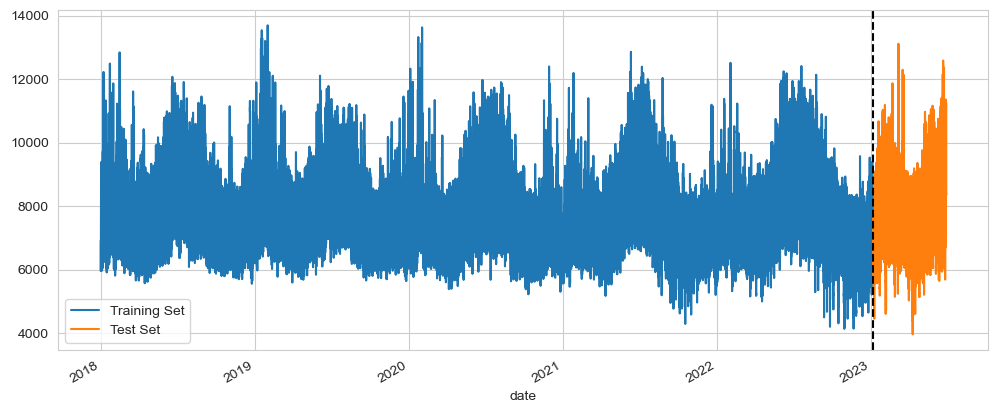

In [33]:
# Calculer l'indice de division
split_index = int(len(df) * 0.8)

train = df.iloc[:split_index]
test = df.iloc[split_index:]

fig, ax = plt.subplots(figsize=(12,5))
train[target_colonne].plot(ax=ax, label="Training Set")
test[target_colonne].plot(ax=ax, label="Test Set")
ax.axvline(pd.to_datetime(df.index[split_index]), color="black", ls="--")
ax.legend(["Training Set","Test Set"])
plt.show()

## Feature Correlation

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 248592 entries, 2018-01-01 00:30:00 to 2023-06-28 00:00:00
Data columns (total 18 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   demande        248592 non-null  float64
 1   prix           248592 non-null  float64
 2   minuteofhour   248592 non-null  int32  
 3   minuteofday    248592 non-null  int32  
 4   minuteofmonth  248592 non-null  int32  
 5   minuteofyear   248592 non-null  int32  
 6   hourofday      248592 non-null  int32  
 7   hourofmonth    248592 non-null  int32  
 8   hourofyear     248592 non-null  int32  
 9   dayofweek      248592 non-null  int32  
 10  dayofmonth     248592 non-null  int32  
 11  dayofyear      248592 non-null  int32  
 12  weekofmonth    248592 non-null  int32  
 13  weekofyear     248592 non-null  UInt32 
 14  month          248592 non-null  int32  
 15  quarter        248592 non-null  int32  
 16  year           248592 non-null  int32  


In [35]:
colonnes_utiles = [col for col in df.columns if col not in target_list]
colonnes_utiles

['prix',
 'minuteofhour',
 'minuteofday',
 'minuteofmonth',
 'minuteofyear',
 'hourofday',
 'hourofmonth',
 'hourofyear',
 'dayofweek',
 'dayofmonth',
 'dayofyear',
 'weekofmonth',
 'weekofyear',
 'month',
 'quarter',
 'year',
 'holidays']

In [36]:
correlation_matrix = df.corr(method='pearson')
sorted_correlations_abs = (correlation_matrix[target_colonne].abs().sort_values(ascending=False)).drop(labels=target_list)
filtered_correlations = sorted_correlations_abs[sorted_correlations_abs >= 0.01]
print(f"Absolute correlations with '{target_colonne}' (Pearson method):\n")
print(filtered_correlations)
#correlation_matrix

Absolute correlations with 'demande' (Pearson method):

hourofday        0.451961
minuteofday      0.449944
prix             0.232052
dayofweek        0.169776
quarter          0.165032
weekofyear       0.152838
month            0.148314
dayofyear        0.146408
minuteofyear     0.145214
hourofyear       0.145210
year             0.071891
hourofmonth      0.040146
minuteofmonth    0.040093
minuteofhour     0.038136
dayofmonth       0.025304
weekofmonth      0.025065
holidays         0.020584
Name: demande, dtype: float64


In [37]:
correlation_matrix = df.corr(method='spearman')
sorted_correlations_abs = (correlation_matrix[target_colonne].abs().sort_values(ascending=False)).drop(labels=target_list)
filtered_correlations = sorted_correlations_abs[sorted_correlations_abs >= 0.01]
print(f"Absolute correlations with '{target_colonne}' (Spearman method):\n")
print(filtered_correlations)
#correlation_matrix

Absolute correlations with 'demande' (Spearman method):

hourofday        0.489796
minuteofday      0.487702
prix             0.444074
dayofweek        0.171799
quarter          0.158976
weekofyear       0.136117
month            0.132253
dayofyear        0.128640
minuteofyear     0.127248
hourofyear       0.127244
minuteofhour     0.040554
hourofmonth      0.038818
minuteofmonth    0.038764
year             0.032018
holidays         0.024851
dayofmonth       0.022935
weekofmonth      0.022258
Name: demande, dtype: float64


### Interprétation Globale des Résultats
SSR based F test : Ce test utilise la somme des résidus carrés (SSR) pour mesurer la proportion de la variance expliquée par les lags de la série temporelle candidate. La statistique F élevée et les p-values extrêmement faibles (0.0000) pour les lags de 1 et 2 indiquent que les lags de `feature` expliquent de manière significative la variation de `target`.
SSR based chi2 test : Ce test transforme la statistique F en une distribution chi-carré pour évaluer l'ajustement du modèle. Les p-values de 0.0000 pour les deux lags montrent que les lags de `feature` ont une influence significative sur `target`.
Likelihood ratio test : Ce test compare la vraisemblance des modèles avec et sans les lags de la série candidate. Les p-values de 0.0000 indiquent que les lags de `feature` ajoutent une valeur prédictive significative au modèle de `target`.
Parameter F test : Ce test est similaire au SSR based F test et vérifie les paramètres du modèle. Les p-values de 0.0000 confirment encore une fois la relation significative entre les lags de `feature` et `target`.

### Conclusion
Les résultats des tests de causalité de Granger montrent une relation de causalité significative entre `feature` et `target`. Les valeurs passées de `feature` sont utiles pour prédire les valeurs futures de `target`, comme indiqué par les p-values très faibles pour tous les tests et pour les lags de 1 et 2 périodes. Cela suggère que `feature` Granger-cause `target`, ce qui est essentiel pour la modélisation et la prévision des séries temporelles dans ce contexte. Plus p est faible (<0.05) plus la variable doit etre utilisee pour la prediction.

In [38]:
max_lag = 1
print("====================================================================================\n")
print(f"Granger Causality Test for '{target_colonne}':")
for i in colonnes_utiles:
    print(i)
    grangercausalitytests(train[[i, target_colonne]], maxlag=max_lag)
    print("---------------------------------------------------------------------------------")
print("\n====================================================================================")


Granger Causality Test for 'demande':
prix

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3036.6031, p=0.0000  , df_denom=198869, df_num=1
ssr based chi2 test:   chi2=3036.6489, p=0.0000  , df=1
likelihood ratio test: chi2=3013.6984, p=0.0000  , df=1
parameter F test:         F=3036.6031, p=0.0000  , df_denom=198869, df_num=1
---------------------------------------------------------------------------------
minuteofhour

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=312.6608, p=0.0000  , df_denom=198869, df_num=1
ssr based chi2 test:   chi2=312.6656, p=0.0000  , df=1
likelihood ratio test: chi2=312.4200, p=0.0000  , df=1
parameter F test:         F=312.6608, p=0.0000  , df_denom=198869, df_num=1
---------------------------------------------------------------------------------
minuteofday

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1639.6586, p=0.0000  , df_denom=198869, df_num=1
ssr based chi2 test:   c

### Maintenant a base des trois resultats precedents, on peut choisir les varialbles explicatives avec lequelles on veux faire la regression.

## Predictions

In [39]:
colonnes_utiles

['prix',
 'minuteofhour',
 'minuteofday',
 'minuteofmonth',
 'minuteofyear',
 'hourofday',
 'hourofmonth',
 'hourofyear',
 'dayofweek',
 'dayofmonth',
 'dayofyear',
 'weekofmonth',
 'weekofyear',
 'month',
 'quarter',
 'year',
 'holidays']

In [40]:
# Création des variables explicatives et de la variable cible
feature = ['prix', 'minuteofhour', 'minuteofday', 'minuteofmonth',
       'minuteofyear', 'hourofday', 'hourofmonth', 'hourofyear', 'dayofweek',
       'dayofmonth', 'dayofyear', 'weekofmonth', 'weekofyear', 'month',
       'quarter', 'year', 'holidays']

In [41]:
x_train = train[feature]
y_train = train[target_colonne]
x_test = test[feature]
y_test = test[target_colonne]

### Recherche des meilleurs parametres

In [42]:
import json

# Chemin du fichier JSON où vous voulez stocker/charger les paramètres optimaux
chemin_fichier_json = "xgboost_parametres_optimaux_xgb.json"

# Fonction pour rechercher les meilleurs paramètres pour XGBoost
def find_best_params_xgb(X_train, y_train):
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 4, 5, 6, 7],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
        'reg_alpha': [0, 0.1, 0.5, 1, 2],
        'reg_lambda': [0, 0.1, 0.5, 1, 2]
    }
    
    # Randomized Search
    random_search = RandomizedSearchCV(XGBRegressor(objective='reg:squarederror'), param_distributions=param_dist, 
                                       n_iter=150, scoring='neg_mean_squared_error', cv=5, verbose=1, random_state=42, n_jobs=-1)
    random_search.fit(X_train, y_train)
    best_params_random = random_search.best_params_
    
    # Narrowed Grid Search
    param_grid = {
        'n_estimators': [best_params_random['n_estimators']-50, best_params_random['n_estimators'], best_params_random['n_estimators']+50],
        'learning_rate': [best_params_random['learning_rate']/2, best_params_random['learning_rate'], best_params_random['learning_rate']*2],
        'max_depth': [best_params_random['max_depth']-1, best_params_random['max_depth'], best_params_random['max_depth']+1],
        'min_child_weight': [best_params_random['min_child_weight']-1, best_params_random['min_child_weight'], best_params_random['min_child_weight']+1],
        'gamma': [best_params_random['gamma']/2, best_params_random['gamma'], best_params_random['gamma']*2],
        'subsample': [max(0.6, best_params_random['subsample']-0.1), best_params_random['subsample'], min(0.9, best_params_random['subsample']+0.1)],
        'colsample_bytree': [max(0.6, best_params_random['colsample_bytree']-0.1), best_params_random['colsample_bytree'], min(0.9, best_params_random['colsample_bytree']+0.1)],
        'reg_alpha': [max(0, best_params_random['reg_alpha']-0.5), best_params_random['reg_alpha'], best_params_random['reg_alpha']+0.5],
        'reg_lambda': [max(0, best_params_random['reg_lambda']-0.5), best_params_random['reg_lambda'], best_params_random['reg_lambda']+0.5]
    }
    
    grid_search = GridSearchCV(XGBRegressor(objective='reg:squarederror'), param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    return best_params

# Vérifier si le fichier JSON existe
if os.path.exists(chemin_fichier_json):
    # Si le fichier JSON existe, lire les paramètres optimaux depuis le fichier
    with open(chemin_fichier_json, 'r') as fichier:
        best_params_xgb = json.load(fichier)
    print("Paramètres optimaux XGBoost récupérés :", best_params_xgb)
else:
    # Si le fichier JSON n'existe pas, exécuter l'algorithme de recherche des paramètres
    # et enregistrer les paramètres optimaux dans le fichier
    best_params_xgb = find_best_params_xgb(x_train, y_train)
    with open(chemin_fichier_json, 'w') as fichier:
        json.dump(best_params_xgb, fichier)
    print("Paramètres optimaux XGBoost enregistrés :", best_params_xgb)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Paramètres optimaux XGBoost enregistrés : {'colsample_bytree': 0.7, 'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 150, 'reg_alpha': 0.6, 'reg_lambda': 2.5, 'subsample': 0.8}


In [55]:
#num_columns = len(feature)
#fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(18, 3*num_columns))
#for i, column in enumerate(feature):
#    axes[i].set_title(f'Statistiques de {column}')
#    axes[i].axis('off')
#    stats = df[column].describe()
#    stats_text = '\n'.join([f'{stat}: {value:.2f}' for stat, value in stats.items()])
#    axes[i].text(0.02, 0.95, stats_text, transform=axes[i].transAxes, fontsize=12, verticalalignment='top')
#plt.tight_layout()
#plt.show()

### Creation du model

In [44]:
# Entraînement du modèle XGBoost avec les meilleurs paramètres
model_xgb = XGBRegressor(objective='reg:squarederror', **best_params_xgb)

### Entrainement du model

In [45]:
# Enregistrer le temps de début
start_time = time.time()

model_xgb.fit(x_train, y_train)

# Enregistrer le temps de fin
end_time = time.time()

In [53]:
colonnes_utiles

['prix',
 'minuteofhour',
 'minuteofday',
 'minuteofmonth',
 'minuteofyear',
 'hourofday',
 'hourofmonth',
 'hourofyear',
 'dayofweek',
 'dayofmonth',
 'dayofyear',
 'weekofmonth',
 'weekofyear',
 'month',
 'quarter',
 'year',
 'holidays']

In [46]:
import xgboost as xgb

# Temps d'entraînement
training_time = end_time - start_time

# Obtenir les scores d'importance des caractéristiques
feature_importances = model_xgb.feature_importances_

# Obtenir des informations générales sur le modèle
model_info = {
    'params': model_xgb.get_params(),
    'n_estimators': model_xgb.n_estimators,
    'training_time_seconds': training_time
}

# Extraire la structure des arbres
booster = model_xgb.get_booster()
dump_model = booster.get_dump(with_stats=True)

# Afficher les résultats
print("Temps d'entraînement: {:.2f} secondes".format(training_time))
print("\nImportance des caractéristiques:")
for i, importance in enumerate(feature_importances):
    print(f"Caractéristique {i}: {importance:.4f}")

print("\nInformations générales sur le modèle:")
for key, value in model_info.items():
    print(f"{key}: {value}")

print("\nStructure des arbres (limité à quelques arbres pour la lisibilité):")
for i, tree in enumerate(dump_model[:5]):  # Limité aux 5 premiers arbres
    print(f"\nArbre {i}:\n")
    print(tree)

Temps d'entraînement: 1.51 secondes

Importance des caractéristiques:
Caractéristique 0: 0.1348
Caractéristique 1: 0.0032
Caractéristique 2: 0.1604
Caractéristique 3: 0.0065
Caractéristique 4: 0.0369
Caractéristique 5: 0.0833
Caractéristique 6: 0.0070
Caractéristique 7: 0.0550
Caractéristique 8: 0.0521
Caractéristique 9: 0.0058
Caractéristique 10: 0.0555
Caractéristique 11: 0.0064
Caractéristique 12: 0.0988
Caractéristique 13: 0.0378
Caractéristique 14: 0.2052
Caractéristique 15: 0.0458
Caractéristique 16: 0.0055

Informations générales sur le modèle:
params: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.05, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_thr

### Phase de prediction

In [47]:
y_pred_xgb = model_xgb.predict(x_test)

### Calcul et affichage de l'erreur

In [48]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

# Affichage des résultats
print("MSE XGBoost:", mse_xgb)

# RSME XGBoost
rmse_xgb = np.sqrt(mse_xgb)
print("RSME XGBoost:", rmse_xgb)

#accuracy
accuracy = model_xgb.score(x_test, y_test)
print("Accuracy XGBoost:", accuracy)

# Calculer la durée d'exécution en secondes
execution_time = end_time - start_time
print("Temps d'exécution :", execution_time, "secondes")

MSE XGBoost: 482759.21686997113
RSME XGBoost: 694.8087628045369
Accuracy XGBoost: 0.6972845069345871
Temps d'exécution : 1.5137419700622559 secondes


### Visualisation des resultats

In [49]:
if target_colonne == target_colonne_original:
    test["prediction"] = y_pred_xgb
else:
    test["prediction_" + target_colonne] = y_pred_xgb
    if k == 0:
        test["prediction"] = np.nan
        for i in range(split_index, len(df)):
            if i - periode < len(train):
                test["prediction"].iloc[i - split_index] = y_pred_xgb[i - split_index] + train[target_colonne].iloc[i - periode]
            else:
                test["prediction"].iloc[i - split_index] = y_pred_xgb[i - split_index] + test["prediction"].iloc[i - split_index - periode]
    else:
        test["prediction_period_diff"] = np.nan
        test["prediction"] = np.nan
        for i in range(split_index, len(df)):
            if i - k < len(train):
                test["prediction_period_diff"].iloc[i - split_index] = y_pred_xgb[i - split_index] + train["period_diff"].iloc[i - k]
            else:
                test["prediction_period_diff"].iloc[i - split_index] = y_pred_xgb[i - split_index] + test["prediction_period_diff"].iloc[i - split_index - k]
            if i - periode < len(train):
                test["prediction"].iloc[i - split_index] = test["prediction_period_diff"].iloc[i - split_index] + train[target_colonne_original].iloc[i - periode]
            else:
                test["prediction"].iloc[i - split_index] = test["prediction_period_diff"].iloc[i - split_index] + test["prediction"].iloc[i - split_index - periode]

C:\Users\DM8196\AppData\Local\Temp\ipykernel_27560\847080435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["prediction"] = y_pred_xgb


In [50]:
print("valeur de k:", k)
print("valeur de periode:", periode)
test[[target_colonne_original, 'prediction']]

valeur de k: 0
valeur de periode: 0


,demande,prediction
date,,
2023-01-06 08:50:00,6887.52,6787.628906
2023-01-06 08:55:00,6851.01,6756.660156
2023-01-06 09:00:00,6860.00,6776.085938
2023-01-06 09:05:00,6902.02,6776.085938
2023-01-06 09:10:00,6962.24,6739.390137
...,...,...
2023-06-27 23:40:00,8536.43,8352.880859
2023-06-27 23:45:00,8527.02,8343.646484
2023-06-27 23:50:00,8489.29,8311.184570


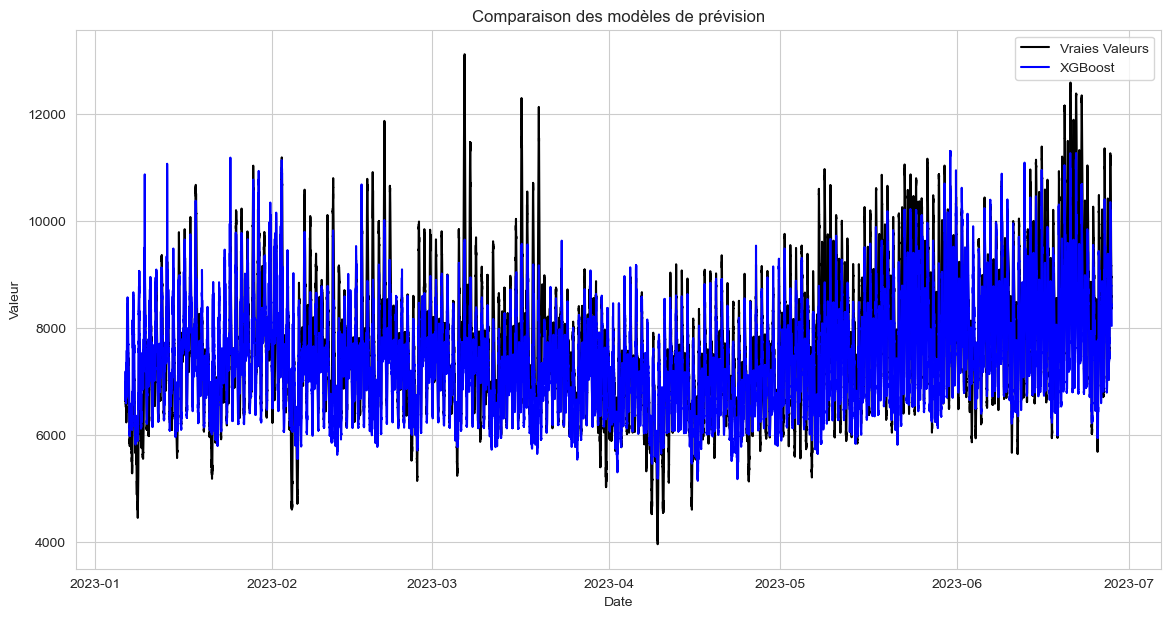

In [51]:
# Visualisation des résultats
plt.figure(figsize=(14, 7))
target_test = test[target_colonne_original]
prediction = test['prediction']
plt.plot(df.index[-len(y_test):], target_test, label='Vraies Valeurs', color='black')
plt.plot(df.index[-len(y_test):], prediction, label='XGBoost', color='blue')

plt.legend()
plt.title('Comparaison des modèles de prévision')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.show()

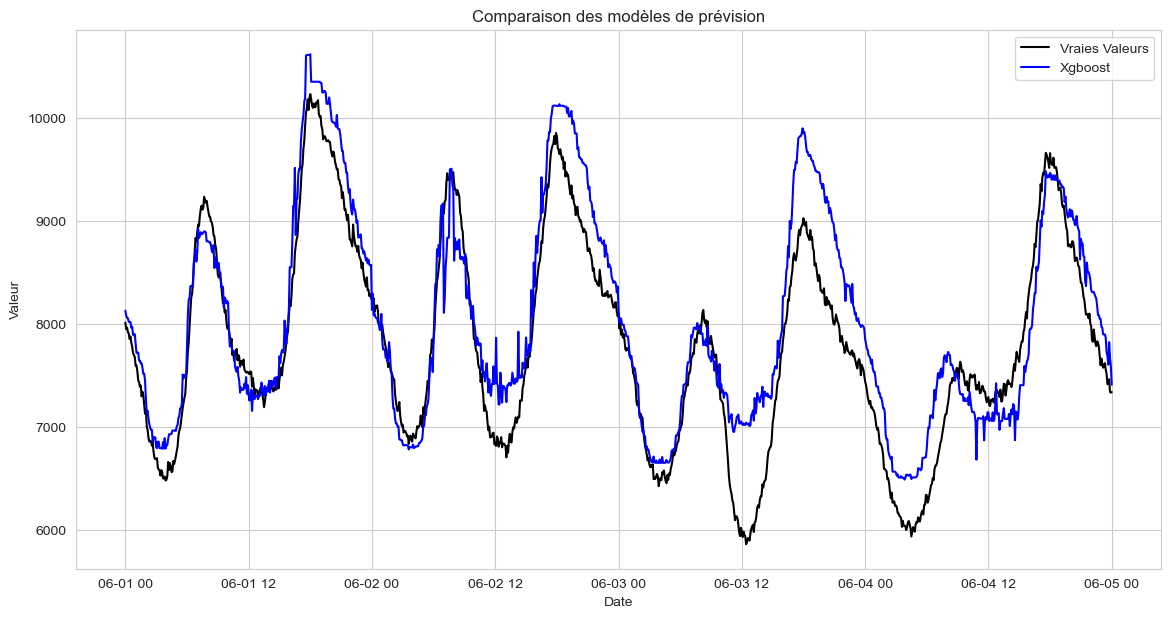

In [52]:
# Définir l'intervalle de dates
start_date = '2023-06-01'
end_date = '2023-06-05'

# Filtrer les données pour cet intervalle
mask = (test.index >= start_date) & (test.index <= end_date)
filtered_dates = test.index[mask]
filtered_y_test = target_test[mask]
filtered_y_pred_rf = prediction[mask]

# Visualisation des résultats pour l'intervalle de dates spécifié
plt.figure(figsize=(14, 7))
plt.plot(filtered_dates, filtered_y_test, label='Vraies Valeurs', color='black')
plt.plot(filtered_dates, filtered_y_pred_rf, label='Xgboost', color='blue')

plt.legend()
plt.title('Comparaison des modèles de prévision')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.show()